# Procesamiento de la cara y las manos con MediaPipe

In [4]:
import cv2
import mediapipe as mp
import os
import yt_dlp
import time

# -------- CONFIGURACIÓN --------
video_url = "https://www.youtube.com/watch?v=rNwnEwlsNSA"
raw_dir = "data/raw"
processed_dir = "data/processed"
input_path = os.path.join(raw_dir, "demo_video_hands_face.mp4") # Nombre archivo entrada
output_path = os.path.join(processed_dir, "landmarks_output_hands_face.mp4") # Nombre archivo salida
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# -------- BORRAR ARCHIVO EXISTENTE (Opcional, pero recomendado para probar) --------
if os.path.exists(input_path):
    print(f"🗑️ Borrando archivo de video RAW existente: {input_path}")
    os.remove(input_path)
# if os.path.exists(output_path):
#     print(f"🗑️ Borrando archivo de video PROCESADO existente: {output_path}")
#     os.remove(output_path)

# -------- DESCARGAR VIDEO --------
if not os.path.exists(input_path):
    print("🔽 Intentando descargar video...")
    try:
        # Usar formato simple que suele funcionar mejor
        ydl_opts = {
            'outtmpl': input_path,
            'format': 'best[ext=mp4]/best',
            'verbose': False # Cambiar a True para más detalles si falla
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([video_url])
        print("✅ Descarga completada.")

        time.sleep(1) # Pequeña pausa
        if os.path.exists(input_path) and os.path.getsize(input_path) > 1024:
             print(f"📊 Archivo descargado: {input_path} ({os.path.getsize(input_path) / (1024*1024):.2f} MB)")
        else:
             print("❌ ¡Error! El archivo no se descargó correctamente o está vacío.")
             exit()

    except Exception as e:
        print(f"❌ Error durante la descarga: {e}")
        exit()
else:
    print(f"🎥 Vídeo ya descargado en: {input_path}")


# -------- MEDIAPIPE SETUP --------
print("🔧 Configurando MediaPipe...")
mp_face_mesh = mp.solutions.face_mesh
mp_hands = mp.solutions.hands # NUEVO: Importar solución Hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles # NUEVO: Para estilos de dibujo predefinidos (opcional)

# Inicializar Face Mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)
print("   - Face Mesh inicializado.")

# NUEVO: Inicializar Hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2, # Detectar hasta dos manos
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)
print("   - Hands inicializado.")

# -------- PROCESAR Y GUARDAR VIDEO --------
print(f"⚙️ Abriendo video para procesar: {input_path}")
cap = cv2.VideoCapture(input_path)

if not cap.isOpened():
    print(f"❌ Error: No se pudo abrir el video en {input_path}")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"🎬 Propiedades del video: {width}x{height} @ {fps:.2f} FPS, Frames Totales: ~{total_frames}")

# Definir codificador y salida
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
print(f"💾 Preparado para guardar video procesado en: {output_path}")

frame_count = 0
# max_frames = 300  # Descomenta y ajusta para limitar frames en pruebas rápidas
print(f"⏳ Procesando frames...")

while cap.isOpened():
    # Descomenta la línea de abajo si pusiste un max_frames
    # if frame_count >= max_frames:
    #     print(f"\n⚠️ Límite de {max_frames} frames alcanzado para prueba.")
    #     break

    ret, frame = cap.read()
    if not ret:
        print(f"\nℹ️ Fin del video o error de lectura en el frame {frame_count}.")
        break

    # 1. Preprocesar frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_rgb.flags.writeable = False # Optimización

    # 2. Procesar con Face Mesh y Hands
    results_face = face_mesh.process(frame_rgb)
    results_hands = hands.process(frame_rgb) # NUEVO: Procesar manos

    # 3. Preparar frame para dibujar (volver a BGR si es necesario o dibujar en el original)
    # Dibujaremos directamente sobre `frame` (BGR)
    frame.flags.writeable = True

    # 4. Dibujar resultados de Face Mesh
    if results_face.multi_face_landmarks:
        for face_landmarks in results_face.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=frame,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                # Estilo para los puntos de la cara (landmarks)
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 255), thickness=1, circle_radius=1), # Magenta
                # Estilo para las conexiones de la cara (malla)
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()) # Estilo por defecto (verde fino)
                # O estilo personalizado:
                # connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)) # Verde

    # 5. NUEVO: Dibujar resultados de Hands
    if results_hands.multi_hand_landmarks:
        for hand_landmarks in results_hands.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image=frame,
                landmark_list=hand_landmarks,
                connections=mp_hands.HAND_CONNECTIONS, # Conexiones de la mano
                # Estilo para los puntos de la mano
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2), # Azul
                # Estilo para las conexiones de la mano
                connection_drawing_spec=mp_drawing_styles.get_default_hand_connections_style()) # Estilo por defecto (blanco/gris)
                # O estilo personalizado:
                # connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=1)) # Cyan

    # 6. Escribir frame procesado al video de salida
    out.write(frame)
    frame_count += 1
    # Mostrar progreso (opcional, puede ralentizar un poco)
    print(f"\r   Frames procesados: {frame_count}/{total_frames if total_frames > 0 else '?'}", end="")


# -------- FINALIZAR --------
print("\n✅ Procesamiento de frames terminado.")

# Liberar recursos
cap.release()
out.release()
face_mesh.close()
hands.close() # NUEVO: Cerrar el objeto Hands
cv2.destroyAllWindows() # Cierra cualquier ventana de OpenCV que pudiera abrirse

print(f"✅ Video procesado con Face Mesh y Hands guardado en: {output_path}")

🔽 Intentando descargar video...
[youtube] Extracting URL: https://www.youtube.com/watch?v=rNwnEwlsNSA
[youtube] rNwnEwlsNSA: Downloading webpage
[youtube] rNwnEwlsNSA: Downloading tv client config
[youtube] rNwnEwlsNSA: Downloading tv player API JSON
[youtube] rNwnEwlsNSA: Downloading ios player API JSON
[youtube] rNwnEwlsNSA: Downloading m3u8 information
[info] rNwnEwlsNSA: Downloading 1 format(s): 18
[download] Destination: data/raw/demo_video_hands_face.mp4
[download] 100% of   64.17MiB in 00:00:16 at 3.95MiB/s   
✅ Descarga completada.
📊 Archivo descargado: data/raw/demo_video_hands_face.mp4 (64.17 MB)
🔧 Configurando MediaPipe...
   - Face Mesh inicializado.
   - Hands inicializado.
⚙️ Abriendo video para procesar: data/raw/demo_video_hands_face.mp4
🎬 Propiedades del video: 640x360 @ 23.98 FPS, Frames Totales: ~34814
💾 Preparado para guardar video procesado en: data/processed/landmarks_output_hands_face.mp4
⏳ Procesando frames...
   Frames procesados: 9/34814

I0000 00:00:1747046555.649874 4097507 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Max
W0000 00:00:1747046555.655190 4155229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1747046555.660213 4097507 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Max
W0000 00:00:1747046555.663193 4155234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747046555.671014 4155239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747046555.680298 4155239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


   Frames procesados: 34814/34814
ℹ️ Fin del video o error de lectura en el frame 34814.

✅ Procesamiento de frames terminado.
✅ Video procesado con Face Mesh y Hands guardado en: data/processed/landmarks_output_hands_face.mp4


# Análisis de ciertas métricas

ℹ️ Analizando video de entrada: data/processed/landmarks_output_hands_face.mp4
🔧 Configurando MediaPipe (necesario para el análisis)...
   - Face Mesh y Hands inicializados.
⚙️ Abriendo video para análisis: data/processed/landmarks_output_hands_face.mp4
🎬 Propiedades del video: @ 23.98 FPS, Frames Totales: ~34814
⏳ Extrayendo métricas de los frames...
   Frames analizados: 11/34814

I0000 00:00:1747048440.896779 4097507 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Max
W0000 00:00:1747048440.898659 4200215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1747048440.902565 4097507 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Max
W0000 00:00:1747048440.903823 4200215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747048440.910947 4200222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747048440.917267 4200222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


   Frames analizados: 34814/34814
ℹ️ Fin del video o error de lectura en el frame 34814.

✅ Análisis de frames terminado.
📊 Generando gráficos de métricas...
✅ Gráfico de métricas guardado en: data/processed/metrics_graph_from_processed.png


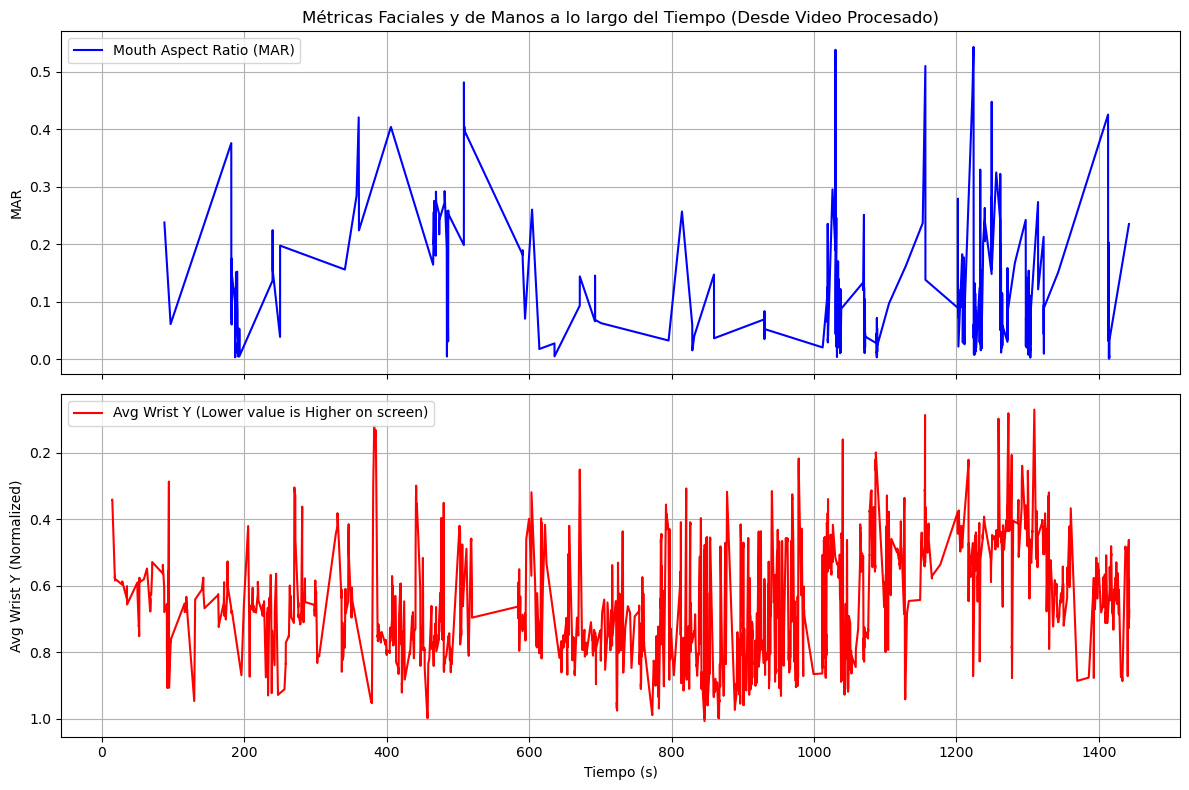

In [5]:
import cv2
import mediapipe as mp
import os
import time
import numpy as np
import math
import matplotlib.pyplot as plt

# -------- CONFIGURACIÓN --------
# Apuntar directamente al video YA PROCESADO en la carpeta 'processed'
processed_dir = "data/processed"
# Nombre del video que ya tiene los landmarks (resultado del script anterior)
input_video_name = "landmarks_output_hands_face.mp4"
input_path = os.path.join(processed_dir, input_video_name)
# Ya no hay un video de salida, solo el gráfico
graph_output_path = os.path.join(processed_dir, "metrics_graph_from_processed.png")

# Asegurarse que el directorio de salida para el gráfico exista
os.makedirs(processed_dir, exist_ok=True)

# -------- VERIFICAR VIDEO DE ENTRADA --------
if not os.path.exists(input_path):
     print(f"❌ Error: El video de entrada procesado {input_path} no existe.")
     print("Asegúrate de haber ejecutado el script anterior para generarlo.")
     exit()
else:
    print(f"ℹ️ Analizando video de entrada: {input_path}")


# -------- MEDIAPIPE SETUP --------
# Necesitamos inicializar MediaPipe igualmente para extraer landmarks,
# aunque ya estén dibujados en el video de entrada.
print("🔧 Configurando MediaPipe (necesario para el análisis)...")
mp_face_mesh = mp.solutions.face_mesh
mp_hands = mp.solutions.hands
# mp_drawing y mp_drawing_styles ya no son estrictamente necesarios si no dibujamos
# pero los dejamos por si se quieren añadir visualizaciones temporales para depurar
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False, max_num_faces=1,
    min_detection_confidence=0.5, min_tracking_confidence=0.5)
hands = mp_hands.Hands(
    static_image_mode=False, max_num_hands=2,
    min_detection_confidence=0.5, min_tracking_confidence=0.5)
print("   - Face Mesh y Hands inicializados.")

# -------- LISTAS PARA GUARDAR MÉTRICAS --------
timestamps = []
mar_values = []
avg_wrist_y_values = []

# -------- FUNCIÓN AUXILIAR PARA CALCULAR DISTANCIA --------
def calculate_distance(p1, p2):
    """Calcula la distancia euclidiana 2D entre dos landmarks de MediaPipe."""
    # Asegurarse que p1 y p2 son objetos landmark válidos
    if p1 and p2:
        return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)
    else:
        return 0 # O manejar el error como prefieras

# -------- PROCESAR VIDEO (SOLO PARA ANÁLISIS) --------
print(f"⚙️ Abriendo video para análisis: {input_path}")
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    print(f"❌ Error: No se pudo abrir el video en {input_path}")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)
# width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # Ya no necesario para salida
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # Ya no necesario para salida
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎬 Propiedades del video: @ {fps:.2f} FPS, Frames Totales: ~{total_frames}")

# Ya NO se define un VideoWriter (fourcc, out)

frame_count = 0
print(f"⏳ Extrayendo métricas de los frames...")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(f"\nℹ️ Fin del video o error de lectura en el frame {frame_count}.")
        break

    # Calcular timestamp actual
    current_time = frame_count / fps if fps > 0 else 0
    timestamps.append(current_time)

    # 1. Preprocesar frame (necesario para MediaPipe)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_rgb.flags.writeable = False # Optimización

    # 2. Procesar con Face Mesh y Hands para OBTENER los landmarks
    #    Aunque el video ya los tenga dibujados, necesitamos los datos numéricos.
    results_face = face_mesh.process(frame_rgb)
    results_hands = hands.process(frame_rgb)

    # 3. Frame ya no necesita ser escribible si no dibujamos
    # frame.flags.writeable = True # No necesario

    # -------- CÁLCULO DE MÉTRICAS --------
    current_mar = None
    current_avg_wrist_y = None

    # Calcular MAR
    if results_face.multi_face_landmarks:
        # Asegurarse de que hay landmarks antes de accederlos
        if results_face.multi_face_landmarks[0].landmark:
            face_landmarks = results_face.multi_face_landmarks[0].landmark

            # Validar que los índices existen (aunque con facemesh deberían)
            try:
                lip_top = face_landmarks[13]
                lip_bottom = face_landmarks[14]
                mouth_left = face_landmarks[61]
                mouth_right = face_landmarks[291]

                ver_dist = calculate_distance(lip_top, lip_bottom)
                hor_dist = calculate_distance(mouth_left, mouth_right)

                if hor_dist > 1e-6:
                    current_mar = ver_dist / hor_dist
                else:
                    current_mar = 0
            except IndexError:
                 print(f"\nAdvertencia: Índice de landmark facial fuera de rango en frame {frame_count}")
                 current_mar = None # O manejar como error

    # Calcular Altura Promedio de Muñecas
    if results_hands.multi_hand_landmarks:
        total_wrist_y = 0
        num_detected_hands = 0
        for hand_landmarks in results_hands.multi_hand_landmarks:
             # Asegurarse de que hay landmarks antes de accederlos
             if hand_landmarks.landmark:
                try:
                    wrist_landmark = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST]
                    total_wrist_y += wrist_landmark.y
                    num_detected_hands += 1
                except IndexError:
                     print(f"\nAdvertencia: Índice de landmark de mano fuera de rango en frame {frame_count}")


        if num_detected_hands > 0:
            current_avg_wrist_y = total_wrist_y / num_detected_hands

    # Guardar métricas calculadas
    mar_values.append(current_mar)
    avg_wrist_y_values.append(current_avg_wrist_y)

    # -------- YA NO SE DIBUJA NADA NI SE ESCRIBE EL FRAME --------
    # (Se omite toda la sección de mp_drawing.draw_landmarks y cv2.putText)
    # (Se omite out.write(frame))

    frame_count += 1
    print(f"\r   Frames analizados: {frame_count}/{total_frames if total_frames > 0 else '?'}", end="")

# -------- FINALIZAR PROCESAMIENTO --------
print("\n✅ Análisis de frames terminado.")
cap.release()
# out.release() # No existe 'out'
face_mesh.close()
hands.close()
cv2.destroyAllWindows()
# print(f"✅ Video procesado con métricas guardado en: {output_path}") # Ya no aplica

# -------- GRAFICAR MÉTRICAS --------
print("📊 Generando gráficos de métricas...")

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Graficar MAR
valid_indices_mar = [i for i, v in enumerate(mar_values) if v is not None]
valid_timestamps_mar = [timestamps[i] for i in valid_indices_mar]
valid_mar = [mar_values[i] for i in valid_indices_mar]

if valid_mar:
    axs[0].plot(valid_timestamps_mar, valid_mar, label='Mouth Aspect Ratio (MAR)', color='blue')
    axs[0].set_ylabel("MAR")
    axs[0].set_title("Métricas Faciales y de Manos a lo largo del Tiempo (Desde Video Procesado)")
    axs[0].grid(True)
    axs[0].legend()
else:
    axs[0].text(0.5, 0.5, 'No se detectó cara consistentemente', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)


# Graficar Altura Promedio de Muñecas (Y)
valid_indices_wrist = [i for i, v in enumerate(avg_wrist_y_values) if v is not None]
valid_timestamps_wrist = [timestamps[i] for i in valid_indices_wrist]
valid_wrist_y = [avg_wrist_y_values[i] for i in valid_indices_wrist]

if valid_wrist_y:
    axs[1].plot(valid_timestamps_wrist, valid_wrist_y, label='Avg Wrist Y (Lower value is Higher on screen)', color='red')
    axs[1].set_ylabel("Avg Wrist Y (Normalized)")
    axs[1].set_xlabel("Tiempo (s)")
    axs[1].invert_yaxis()
    axs[1].grid(True)
    axs[1].legend()
else:
     axs[1].text(0.5, 0.5, 'No se detectaron manos consistentemente', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)


plt.tight_layout()
plt.savefig(graph_output_path) # Guardar gráfico en la nueva ruta
print(f"✅ Gráfico de métricas guardado en: {graph_output_path}")
plt.show()